In [1]:
from collections import defaultdict
import pandas as pd
import glob

class KrakenEntry:
    def __init__(self, row=None, domain=None, hierarchy=[]):
        self.taxon_id = 0
        self.name = "unclassified"
        self.rank = "U"
        self.depth = 0
        self.count = 0 # inclusive count
        self.ucount = 0 # unique_count
        self.domain = domain
        self.parent = None
        self.children = set()
        self.sibling_rank = 0
        self.hierarchy = hierarchy
        if row is not None:
            self.add_row(row)
    
    def print(self):
        print(f"{self.taxon_id},{self.name},{self.rank},{self.depth},{self.count},{self.ucount},{self.domain},{self.parent},{self.children},{self.sibling_rank},{self.hierarchy}")
    
    def parse_depth(self, name):
        parse_name = name.split(" ")
        depth = 0
        for i in parse_name:
            if i != "":
                break
            depth += 1
        depth = int(depth / 2)
        return depth
        
    def add_row(self, row):
        self.taxon_id = row["Taxonomy ID"]
        self.name = row["Scientific Name"].strip()
        self.depth = self.parse_depth(row["Scientific Name"])
        self.rank = row["Rank"]
        self.count = row["Clades"] # inclusive count
        self.ucount = row["Taxonomies"] # unique_count
        self.hierarchy = self.hierarchy[:self.depth]

    def add_parent(self, parent):
        self.parent = parent
        
    def add_child(self, child):
        self.children.add(child)

    def set_sibling_rank(self, rank):
        self.sibling_rank = rank
      
class KrakenReport:
    def __init__(self, file_name=None):
        self.entries = defaultdict(KrakenEntry)
        self.total = 0
        self.unclassified = 0
        self.classified = 0
        self.domains = defaultdict(int)
        if file_name:
            self.load_df(file_name)
            self.unclassified = self.entries[0].count
            self.classified = self.entries[1].count
            self.total = self.classified + self.unclassified
            
    def add_parent_child(self, parent_id, child_id):
        self.entries[child_id].add_parent(parent_id)
        self.entries[parent_id].add_child(child_id)
        
    def set_sibling_ranks(self):
        for entry_id, entry in self.entries.items():
            if entry.sibling_rank > 0 or entry.parent in [None, 1, 131567]:
                continue
            if entry.rank in ["D", "R", "R1"]:
                entry.set_sibling_rank(1)
            elif len(self.entries[entry.parent].children) == 1:
                entry.set_sibling_rank(1)
            else:
                sibling_dict = {i:self.entries[i].count for i in self.entries[entry.parent].children}
                sorted_counts = sorted(sibling_dict.values(), reverse=True)
                for i,c in sibling_dict.items():
                    rank = sorted_counts.index(c) + 1
                    self.entries[i].set_sibling_rank(rank)
                    
    def check_sibling_ranks(self):
        for entry_id in self.entries:
            if self.entries[entry_id].sibling_rank == 0:
                print(entry_id)
                     
    def load_df(self, file_name):
        df = pd.read_csv(file_name, sep="\t", skipinitialspace = False)
        hierarchy = []
        domain = None
        for i,row in df.iterrows():
            try:
                if row["Rank"] == "D":
                    domain = row["Scientific Name"].strip()
                    self.domains[domain] = row["Taxonomy ID"]
                entry = KrakenEntry(row=row, domain=domain, hierarchy=hierarchy)

            except:
                print(f"Found badly formatted row:\n{row}")
                print(f"Quitting load of {file_name}")
                break
            
            self.entries[entry.taxon_id] = entry
            hierarchy = entry.hierarchy.copy()
            if len(hierarchy) > 0:
                self.add_parent_child(hierarchy[-1], entry.taxon_id)
            if entry.taxon_id > 0:
                hierarchy.append(entry.taxon_id)
        self.set_sibling_ranks()
        #self.check_sibling_ranks()

    def get_domains(self):
        domains = []
        for entry_id, entry in self.entries.items():
            if entry.rank == "D":
                domains.append(entry)
                entry.print()
        return domains

    def get_percentage(self, taxon_id, domain=None):
        
        if domain and self.entries[taxon_id].domain!=domain:
            return 0.0
            
        denominator = self.classified
        if domain:
            denominator = self.entries[self.domains[domain]].count
            
        count=self.entries[taxon_id].count
        return float(count)/denominator

    def to_source_target_df(self, max_rank=None, domain=None, trace_ids=[]):
        records = []
        ignore = set()
        skip = set()
        for entry_id, entry in self.entries.items():
            
            # we don't want the connections to cellular organisms, root etc
            if entry.sibling_rank == 0:
                continue
                
            # filter by domain where required
            if domain and entry.domain!=domain:
                continue
                
            # filter by rank when specified
            if max_rank:
                if entry.sibling_rank > max_rank:
                    ignore.add(entry_id)
                    if entry_id in trace_ids:
                        print(entry_id, 1)
                    continue
                elif entry.parent in ignore:
                    ignore.add(entry_id)
                    if entry_id in trace_ids:
                        print(entry_id, 2)
                    continue

            # filter if an intermediate rank
            if entry.rank not in ["K","D","D1","D2","P","C","O","F","G","S", "S1", "S2"]:
                skip.add(entry_id)
                if entry_id in trace_ids:
                    print(entry_id, 3)
                continue
            
            index = 1
            while index < len(entry.hierarchy) and entry.hierarchy[-index] in skip:
                index += 1
            source_id = entry.hierarchy[-index]
            if entry_id in trace_ids:
                print(entry_id, 4, source_id)
            records.append({"source":self.entries[source_id].name, "target": entry.name, "value":entry.count, "percentage":self.get_percentage(entry_id, domain=domain)})

        all_links = pd.DataFrame.from_records(records)
        all_links.to_csv("source_target.csv")

        print(len(records), len(ignore), len(skip))

        return records

    def to_df(self, sample_id="sample_id", ranks=[]):
        if not ranks or len(ranks) == 0:
            taxon_ids =  [e for e in self.entries.keys()]
        else:
            taxon_ids =  [e for e in self.entries.keys() if self.entries[e].rank in ranks]
        return pd.DataFrame({sample_id:[self.entries[e].count for e in taxon_ids]}, index=taxon_ids)
        

In [233]:
from dash import Dash, dcc, html, Input, Output
import plotly.graph_objects as go

app = Dash(__name__)

app.layout = html.Div([
    dcc.Graph(id="graph"),
    dcc.Slider(id="slider", min=0, max=100, step=0.1, value=1,
    marks={
        0: "0",
        1: "1",
        5: "5",
        10: "10",
        100: "100"
    }),
    html.Div(id='updatemode-output-container', style={'marginTop': 20})
])

@app.callback(Output('updatemode-output-container', 'children'),
              Input('slider', 'value'))
def display_value(value):
    return f"Minimum percentage: {value}"

@app.callback(
    Output("graph", "figure"), 
    Input("slider", "value"))
def update_sankey(min_percent):
    all_links = pd.read_csv("source_target.csv")
        
    #for using with 'label' parameter in plotly 
    #https://sparkbyexamples.com/pandas/pandas-find-unique-values-from-columns
    unique_source_target = list(pd.unique(all_links[['source', 'target']].values.ravel('K')))
        
    #for assigning unique number to each source and target
    mapping_dict = {k: v for v, k in enumerate(unique_source_target)}
        
    #mapping of full data
    all_links['source'] = all_links['source'].map(mapping_dict)
    all_links['target'] = all_links['target'].map(mapping_dict)
        
    #converting full dataframe as list for using with in plotly
    all_links = all_links[all_links["percentage"] > float(min_percent)/100]
    links_dict = all_links.to_dict(orient='list')
        
    #Sankey Diagram Code 
    fig = go.Figure(data=[go.Sankey(
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(color = "black", width = 0.5),
          label = unique_source_target,
              
        ),
        link = dict(
          source = links_dict["source"],
          target = links_dict["target"],
          value = links_dict["value"],
        ))],
        layout_title_text="Kraken Report Sankey Diagram"
    )
    return fig

app.run_server(debug=True)

In [224]:
from skbio.stats.composition import clr

class KrakenCombined:
    def __init__(self, list_file_names=[], metadata=None, counts=None, taxa=None, ranks=[]):
        self.metadata = pd.DataFrame(columns=["group","pass","classified","unclassified","total"])
        if metadata:
            self.metadata = pd.read_csv(metadata, index_col=0)
        self.counts = pd.DataFrame()
        if counts:
            self.counts = pd.read_csv(counts, index_col=0)
        self.taxa = pd.DataFrame()
        if taxa:
            self.taxa = pd.read_csv(taxa, index_col=0)
        for file_name in list_file_names:
            k = KrakenReport(file_name)
            sample_id = file_name.split("/")[-1].split(".")[0]
            self.add_kraken_report_to_metadata(k, sample_id)
            self.add_kraken_report_to_counts(k, sample_id, ranks=ranks)
            
    def add_kraken_report_to_metadata(self, kraken_report, sample_id):
        update = {"group": "default", "pass":True, "classified":kraken_report.classified, "unclassified":kraken_report.unclassified, "total":kraken_report.total}
        self.metadata.loc[sample_id] = update

    def add_kraken_report_to_counts(self, kraken_report, sample_id, ranks=[]):
        self.counts = self.counts.join(kraken_report.to_df(sample_id, ranks=ranks), how='outer')
        self.counts.fillna(0, inplace=True)
        self.counts = self.counts.astype('int64')

    def load_metadata(self, metadata_csv):
        with open(metadata_csv, "r") as f:
            for line in f:
                sample_id, group = line.strip().split(",")
                self.metadata.loc[sample_id, "group"] = group

    def normalize_counts(self, by="total"):
        self.normed_counts = self.counts
        for sample_id in self.normed_counts.columns:
            self.normed_counts[sample_id] = self.normed_counts[sample_id]/self.metadata.loc[sample_id, "total"]
        if by == "total":
            return
        x = self.normed_counts.T
        y = clr(x) 

    def filter_samples(self, min_count=10):
        self.metadata["pass"] = self.metadata["pass"].fillna(False)
        num_taxa_in_samples = self.counts.astype(bool).sum(axis=0)
        for i,c in num_taxa_in_samples.items():
            self.metadata.loc[i,"pass"] = (c > min_count)

    def get_taxa_info(self):
        self.taxa = self.counts.astype(bool).sum(axis=1).to_frame("count_samples")
        self.taxa["percent_samples"] = self.taxa["count_samples"]/self.counts.shape[1]*100
        self.taxa["min"] = self.counts.min(axis=1)
        self.taxa["max"] = self.counts.max(axis=1)
        self.taxa["mean"] = self.counts.mean(axis=1)
        self.taxa["median"] = self.counts.median(axis=1)
        self.taxa["count_reads"] = self.counts.sum(axis=1)
        overall_total = self.counts.sum().sum()
        self.taxa["percent_reads"] = self.taxa["count_reads"]/overall_total*100

    def filter_taxa(self, min_percent_of_samples=5, min_number_of_samples=2, min_percent_of_reads = 0.01):
        self.get_taxa_info()
        pass_percent = self.taxa["percent_samples"] >= min_percent_of_samples
        pass_count = self.taxa["count_samples"] >= min_number_of_samples
        pass_percent_taxa = self.taxa["percent_reads"] >= min_percent_of_reads
        self.taxa["pass"] = pass_percent & pass_count & pass_percent_taxa

    def get_taxa(self):
        return self.taxa[self.taxa["pass"]]

    def get_samples(self):
        return self.metadata[self.metadata["pass"]]

    def save(self, prefix):
        metadata.to_csv(f"{prefix}.metadata.csv")
        counts.to_csv(f"{prefix}.counts.csv")
        taxa.to_csv(f"{prefix}.taxa.csv")

In [225]:
list_kraken_reports = glob.glob("data/*.PlusPF.kraken_report.txt")
kc = KrakenCombined(list_kraken_reports, ranks=["G"])
kc.save("data/test")

NameError: name 'metadata' is not defined

In [ ]:
g = pd.read_csv("data/combined.csv", header=None, names=["sample_id","group"], index_col=0)
kc.metadata.update(g)
kc.filter_taxa()
kc.filter_samples()
kc.save("data/test2")

In [220]:
from skbio.stats.composition import clr

normed_counts = kc.counts
for sample_id in normed_counts.columns:
    normed_counts[sample_id] = (normed_counts[sample_id]+1)/kc.metadata.loc[sample_id, "total"]
x = normed_counts.T
y = clr(x).T

In [223]:
normed_counts.values[normed_counts.index, normed_counts.columns] = y

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [210]:
by

NameError: name 'by' is not defined

In [198]:
mamba install --yes --quiet -c conda-forge scikit-bio


Note: you may need to restart the kernel to use updated packages.


In [191]:
kc.get_taxa()

,count_samples,percent_samples,min,max,mean,median,count_reads,percent_reads,pass
157,10,100.0,769,5764,3254.8,3680.0,32548,0.021096,True
194,10,100.0,455,9284,2497.3,1285.0,24973,0.016186,True
237,10,100.0,7,17189,2862.8,656.5,28628,0.018555,True
286,10,100.0,22,16047,4783.3,1966.5,47833,0.031002,True
482,10,100.0,556,588121,61337.4,1970.5,613374,0.397551,True
...,...,...,...,...,...,...,...,...,...
2948785,5,50.0,0,18307,3236.9,5.0,32369,0.020980,True
3025755,10,100.0,1,58011,15286.7,7592.5,152867,0.099079,True
3046369,6,60.0,0,9499,2784.2,609.5,27842,0.018045,True
3047433,6,60.0,0,7473,1941.6,559.0,19416,0.012584,True


In [180]:
kc.metadata

,group,pass,classified,unclassified,total
SRR9684969,oral2,True,12588100.0,112602.0,12700702.0
ERR1711741,gut2,True,22752015.0,17955429.0,40707444.0
ERR1711699,gut2,True,40184284.0,35254459.0,75438743.0
ERR1711776,gut2,True,17578605.0,21187571.0,38766176.0
ERR1711718,gut2,True,57875446.0,22319162.0,80194608.0
...,...,...,...,...,...
SRR9685005,oral2,False,NaN,NaN,NaN
SRR9685006,oral2,False,NaN,NaN,NaN
SRR9685007,oral2,False,NaN,NaN,NaN
SRR9685008,oral2,False,NaN,NaN,NaN


In [5]:
with open("data/combined.csv", "r") as f:
    for line in f:
        sample_id, group = line.strip().split(",")
        kc.metadata[sample_id]["group"] = group

In [48]:
#kc.normalize_counts()
kc.filter_samples()
kc.filter_taxa()

In [56]:
kc.metadata

""


In [ ]:
%%R 

In [91]:
kc.normalize_counts()
kc.counts

,SRR9684969,ERR1711741,ERR1711699,ERR1711776,ERR1711718,SRR2193647,SRR2221476,SRR2188500,SRR2194525,ERR1711673,...,ERR1711751,SRR9684993,SRR2223609,SRR2224242,SRR9966495,SRR2188671,SRR2224484,SRR2224837,SRR9966514,SRR9966523
6,0.0,1.424761e+09,1.010879e+10,1.977075e+09,1.443503e+09,0.0,0.0,0.0,0.0,4.301566e+08,...,3.021207e+09,0.0,0.0,0.0,12339552.0,0.0,0.0,0.0,2349750.0,0.000000e+00
10,0.0,2.238909e+09,1.214564e+10,4.458110e+09,1.138763e+10,0.0,0.0,1064678.0,286654.0,6.765190e+09,...,6.564599e+09,40436538.0,83068664.0,0.0,12339552.0,399122.0,0.0,225040.0,939900.0,2.236826e+08
13,0.0,5.699042e+08,6.110538e+09,1.550647e+09,6.736347e+09,0.0,0.0,1064678.0,0.0,1.016734e+09,...,1.454655e+09,13478846.0,14659176.0,0.0,18509328.0,0.0,0.0,0.0,0.0,2.982434e+07
16,0.0,1.730066e+10,1.010879e+10,2.907463e+09,3.528563e+09,213058.0,0.0,2129356.0,0.0,1.446890e+09,...,4.102874e+09,0.0,34204744.0,0.0,0.0,0.0,0.0,0.0,939900.0,7.456085e+07
18,0.0,1.510246e+10,1.116493e+10,4.690707e+09,4.651287e+09,0.0,0.0,0.0,0.0,1.173154e+09,...,3.506092e+09,0.0,0.0,0.0,2056592.0,0.0,0.0,0.0,0.0,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3075137,12700702.0,2.564569e+09,3.696498e+09,3.411423e+09,2.245449e+09,0.0,0.0,0.0,0.0,7.429978e+08,...,2.349828e+09,0.0,0.0,0.0,28792288.0,399122.0,0.0,0.0,3759600.0,2.982434e+07
3076095,12700702.0,5.699042e+08,2.036846e+09,3.101294e+08,3.207784e+08,0.0,0.0,0.0,0.0,6.647875e+08,...,4.848851e+08,0.0,9772784.0,0.0,0.0,0.0,0.0,0.0,0.0,1.789460e+08
3076670,0.0,1.682032e+11,5.385572e+11,9.350402e+10,6.786068e+11,0.0,0.0,0.0,0.0,1.202092e+11,...,1.805638e+11,53915384.0,68409488.0,879432.0,0.0,399122.0,0.0,0.0,0.0,0.000000e+00
3076685,0.0,8.548563e+08,7.166681e+09,1.124219e+09,1.283114e+09,0.0,0.0,0.0,0.0,2.346309e+08,...,1.081667e+09,0.0,0.0,0.0,4113184.0,0.0,0.0,0.0,469950.0,0.000000e+00


In [98]:
nz = kc.counts["SRR9684969"][kc.counts["SRR9684969"] > 0]

In [106]:
nz

20          1
22         21
32          2
50          2
59         58
           ..
3050898     5
3051137     3
3051458     2
3075137     1
3076095     1
Name: SRR9684969, Length: 793, dtype: int64

In [ ]:
sns.histplot(x=nz)

In [ ]:
sns.set(color_codes=True)
sns.set(style="white", palette="muted")
sns.distplot(nz)

#for col_id in kc.counts.columns[:3]:
#    sns.histplot(kc.counts[col_id])

In [16]:
kc.counts["ERR1711656"].dtype == 'float64'

True

In [54]:
kc.taxa[kc.taxa["mean"]>0.01]

,count,min,max,mean,mdiean,percent
475,536,0.000000e+00,0.779328,0.019496,0.000009,0.955437
482,561,2.662239e-06,0.222834,0.013372,0.000108,1.000000
816,560,0.000000e+00,0.503522,0.055052,0.000207,0.998217
838,561,5.410210e-07,0.260674,0.015475,0.000738,1.000000
1301,561,7.795499e-05,0.733655,0.042052,0.002869,1.000000
9605,561,3.532241e-05,0.986364,0.285253,0.167560,1.000000
239759,553,0.000000e+00,0.267615,0.014677,0.000043,0.985740
909656,545,0.000000e+00,0.433840,0.019493,0.000033,0.971480


In [59]:
from scipy import stats

dist = stats.gamma
bounds = [(0, 1), (0, 1)]
data = [c for c in kc.counts.loc[475,:] if c > 0.001]
res = stats.fit(dist, data, bounds)


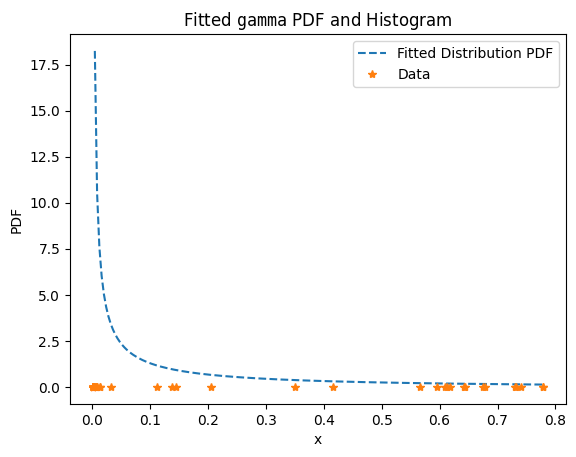

In [60]:
import matplotlib.pyplot as plt  # matplotlib must be installed to plot
res.plot()
plt.show()

In [30]:
pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 3.2 MB/s eta 0:00:00a 0:00:01
  Using cached kiwisolver-1.4.5-cp310-cp310-macosx_10_9_x86_64.whl.metadata (6.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 56.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.8/260.8 kB 11.2 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 48.3 MB/s eta 0:00:0000:01
Using cached kiwisolver-1.4.5-cp310-cp310-macosx_10_9_x86_64.whl (68 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 58.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 4.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [213]:
s = k.to_source_target_df(max_rank=2, domain="Archaea")

14594 0 1057


In [232]:
s = k.to_source_target_df(max_rank=1)

33 15621 24


In [219]:
ids = [2,2290931,183963,2235]
for i in ids:
    k.entries[i].print()

2,Bacteria,D,2,25419649,272915,Bacteria,131567,{2138240, 49928, 2323, 2498710, 74152, 508458, 203691, 68525, 3018035, 40117, 32066, 1224, 2818505, 68297, 200783, 200918, 1783257, 200930, 1802340, 1783270, 1783272, 200938, 29547, 200940, 67818, 1930617, 57723},0,[1, 131567]
2290931,Stenosarchaea group,P1,4,6441,106,Archaea,28890,{183963, 224756},2,[1, 131567, 2157, 28890]
183963,Halobacteria,C,5,4415,570,Archaea,2290931,{2235, 1644060, 1644055},1,[1, 131567, 2157, 28890, 2290931]
2235,Halobacteriales,O,6,1931,62,Archaea,183963,{2976354, 1963268, 1963270, 2236, 3064797},1,[1, 131567, 2157, 28890, 2290931, 183963]


In [127]:
for r in s:
    if r["percentage"] > 0.005:
        print(r)
        #k.entries[r["target"]].print()

{'source': 'Archaea', 'target': 'Euryarchaeota', 'value': 146391, 'percentage': 0.9939773761186328}
{'source': 'Euryarchaeota', 'target': 'Methanobacteria', 'value': 138535, 'percentage': 0.940636075992341}
{'source': 'Methanobacteria', 'target': 'Methanobacteriales', 'value': 138535, 'percentage': 0.940636075992341}
{'source': 'Methanobacteriales', 'target': 'Methanobacteriaceae', 'value': 138519, 'percentage': 0.9405274379065441}
{'source': 'Methanobacteriaceae', 'target': 'Methanobrevibacter', 'value': 137686, 'percentage': 0.9348714675647415}
{'source': 'Methanobrevibacter', 'target': 'Methanobrevibacter smithii', 'value': 125658, 'percentage': 0.8532027865669007}
{'source': 'Methanobrevibacter smithii', 'target': 'Methanobrevibacter smithii ATCC 35061', 'value': 30787, 'percentage': 0.2090400467143769}


In [23]:
k.get_domains()

2,Bacteria,D,2,25419649,272915,Bacteria,131567,{2138240, 49928, 2323, 2498710, 74152, 508458, 203691, 68525, 3018035, 40117, 32066, 1224, 2818505, 68297, 200783, 200918, 1783257, 200930, 1802340, 1783270, 1783272, 200938, 29547, 200940, 67818, 1930617, 57723},1,[1, 131567]
2157,Archaea,D,2,147278,28,Archaea,131567,{1783275, 1783276, 1935183, 2283796, 28890},1,[1, 131567]
2759,Eukaryota,D,2,19264,252,Eukaryota,131567,{33154, 554915, 2611341, 2698737, 3027, 2611352},1,[1, 131567]
10239,Viruses,D,1,200970,7,Viruses,1,{2559587, 2732004, 12429, 2731341, 2731342, 2840056},1,[1]


In [173]:
s = k.to_sankey(max_rank=2, domain="Eukaryota")

180 208 55
{'source': [0, 1, 2, 3, 4, 5, 6, 7, 1, 8, 9, 10, 11, 12, 13, 14, 14, 15, 13, 13, 16, 13, 11, 17, 18, 17, 19, 10, 20, 21, 22, 23, 22, 10, 24, 25, 26, 26, 10, 27, 28, 29, 30, 28, 31, 32, 27, 33, 34, 35, 9, 36, 37, 38, 39, 40, 9, 41, 42, 43, 44, 44, 43, 45, 42, 46, 47, 47, 9, 48, 49, 50, 51, 52, 51, 53, 50, 54, 55, 54, 56, 49, 57, 58, 59, 58, 60, 57, 61, 62, 9, 63, 64, 65, 66, 66, 8, 67, 68, 69, 70, 71, 69, 72, 73, 68, 74, 75, 76, 67, 77, 78, 79, 80, 81, 67, 82, 83, 84, 85, 85, 86, 8, 87, 88, 89, 90, 89, 91, 0, 92, 93, 94, 95, 96, 97, 98, 98, 99, 98, 98, 95, 100, 101, 102, 102, 103, 102, 104, 100, 105, 106, 106, 107, 94, 108, 109, 110, 111, 110, 112, 113, 109, 114, 115, 116, 92, 117, 118, 119, 120, 121, 122, 123, 118, 124, 125, 126, 127, 128], 'target': [1, 2, 3, 4, 5, 6, 7, 129, 8, 9, 10, 11, 12, 13, 14, 130, 15, 131, 132, 16, 133, 134, 17, 18, 135, 19, 136, 20, 21, 22, 23, 137, 138, 24, 25, 26, 139, 140, 27, 28, 29, 30, 141, 31, 32, 142, 33, 34, 35, 143, 36, 37, 38, 39, 40, 1

In [220]:
trace_ids = [1783270]
s = k.to_source_target_df(max_rank=2, trace_ids=trace_ids)
for i in trace_ids:
    k.entries[i].print()
for r in s:
    if r["source"] == 2759:
        print(r)
        k.entries[r["target"]].print()
        #k.entries[r["target"]].print()

1155 14351 145
1783270,FCB group,D1,3,10199270,33,Bacteria,2,{68336, 65842, 456828, 142182},0,[1, 131567, 2]


In [186]:
from dash import Dash, dcc, html, Input, Output
import plotly.graph_objects as go
import numpy as np

app = Dash(__name__)

app.layout = html.Div([
    html.H4('Interactive plot with custom data source'),
    dcc.Graph(id="graph"),
    html.P("Number of bars:"),
    dcc.Slider(id="slider", min=2, max=10, value=4, step=1),
])


@app.callback(
    Output("graph", "figure"), 
    Input("slider", "value"))
def update_bar_chart(size):
    data = np.random.normal(3, 2, size=size) # replace with your own data source
    fig = go.Figure(
        data=[go.Bar(y=data)],
        layout_title_text="Native Plotly rendering in Dash"
    )
    return fig

app.run_server(debug=True)

In [9]:
import plotly.express as px
fig = px.bar(x=["a", "b", "c"], y=[1, 3, 2])

import plotly.graph_objects as go
fig_widget = go.FigureWidget(fig)
fig_widget

FigureWidget({
    'data': [{'alignmentgroup': 'True',
              'hovertemplate': 'x=%{x}<br>y=%{y}<extra></extra>',
              'legendgroup': '',
              'marker': {'color': '#636efa', 'pattern': {'shape': ''}},
              'name': '',
              'offsetgroup': '',
              'orientation': 'v',
              'showlegend': False,
              'textposition': 'auto',
              'type': 'bar',
              'uid': '7737103a-1c3f-4878-8585-90c84b49e956',
              'x': array(['a', 'b', 'c'], dtype=object),
              'xaxis': 'x',
              'y': array([1, 3, 2]),
              'yaxis': 'y'}],
    'layout': {'barmode': 'relative',
               'legend': {'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'x'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'y'}}}
})

In [11]:
conda install -c conda-forge python-kaleido

Retrieving notices: ...working... done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.1.0
  latest version: 24.5.0

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.5.0



## Package Plan ##

  environment location: /opt/miniconda3

  added / updated specs:
    - python-kaleido


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-3.1.5              |       h87427d6_1         2.2 MB  conda-forge
    python-kaleido-0.2.1       |   py39hecd8cb5_0          25 KB
    ------------------------------------------------------------
                                           Total:         2.2 MB

The following NEW packages will be INSTALLED:

  kaleido-core       conda-forge/osx-64::kaleido-core-0.2.1-h0d85af4_0

In [9]:
pip install --upgrade jupyterlab-plotly

ERROR: Could not find a version that satisfies the requirement jupyterlab-plotly (from versions: none)
ERROR: No matching distribution found for jupyterlab-plotly
Note: you may need to restart the kernel to use updated packages.


In [10]:
import plotly.graph_objects as go
fig = go.Figure(
    data=[go.Bar(y=[2, 1, 3])],
    layout_title_text="A Figure Displayed with fig.show()"
)
fig.show()

In [11]:
pip install "jupyterlab>=3"

Note: you may need to restart the kernel to use updated packages.


In [5]:
import plotly.express as px
fig = px.bar(x=["a", "b", "c"], y=[1, 3, 2])
fig.write_html('first_figure.html', auto_open=True)

In [37]:
def rank_diff(rank1, rank2):
        rank_order = ["U","K","D","P","C","O","F","G","S"]
        if rank1 == rank2:
            return 0

        prefix1 = rank_order.index(rank1[0])
        prefix2 = rank_order.index(rank2[0])
        assert(prefix2 - prefix1 <= 1)
        if prefix2 < prefix1:
            return prefix2 - prefix1

        suffix1, suffix2 = 0,0
        if len(rank1) > 1:
            suffix1 = int(rank1[1:])
        if len(rank2) > 1:
            suffix2 = int(rank2[1:])

        print(prefix1, prefix2, suffix1, suffix2)

        if prefix1 == prefix2:
            assert(suffix2 - suffix1 <= 1)
            return suffix2 - suffix1
        elif prefix2 - prefix1 == 1:
            assert(suffix2 == 0)
            return 1
        else:
            return suffix2 - suffix1

In [43]:
rank_diff("D1","S1")

AssertionError: 

In [4]:
import os
import glob
import pandas as pd

# Directory containing the text files
directory = "data/"

def load_virus_df(file_name, ranks=["F"], unclassified_percentages = [], restrict_to_virus = True):
    df = pd.read_csv(file_name, sep="\t", skipinitialspace = True)

    # identify the percentage unclassified
    unclassified = df.iloc[0]["% of Seqs"]
    unclassified_percentages.append(unclassified)

    # restrict to viruses only
    if restrict_to_virus:
        virus_index = df.index[df["Taxonomy ID"] == 10239][0]
        percent_virus = df.iloc[virus_index]["% of Seqs"]
        df.drop(range(virus_index), inplace=True)
        
        domain_indices = df.index[df["Rank"] == "D"]
        if len(domain_indices) > 1:
            print(file_name, domain_indices)
            df.drop(range(domain_indices[1],len(df.index)), inplace=True)
        
        df["percentage_of_classified_virome"] = df["% of Seqs"]/percent_virus
    else:
        df["percentage_of_classified"] = df["% of Seqs"]/df.iloc[1]["% of Seqs"]


    # restrict to families
    df = df[df["Rank"].isin(ranks)]
    return df

def add_to_master_df(df, name, master, column):
    df = df.set_index("Scientific Name")
    df[name] = df[column]
    sdf = df[[name]]
    if master.empty:
        return sdf
    else:
        master = master.join(sdf, how='outer')
        master.fillna(0, inplace=True)
        return master

def get_data_for_niche(directory, restrict_to_virus=True):
    count_master = pd.DataFrame()
    percent_master = pd.DataFrame()
    unclassified_percentages = []
    
    # Loop over each subdirectory in the main directory
    files = glob.glob("%s/*kraken_report.txt" %(directory))
    for file_name in files:
        print(file_name)
        df = load_virus_df(file_name, ranks=["F"], unclassified_percentages=unclassified_percentages, restrict_to_virus=restrict_to_virus)
        name = file_name.split("/")[-1].split(".")[0]
        print(name)
        
        count_master = add_to_master_df(df, name, count_master, "Clades")
        if restrict_to_virus:
            percent_master = add_to_master_df(df, name, percent_master, "percentage_of_classified_virome")
        else:
            percent_master = add_to_master_df(df, name, percent_master, "percentage_of_classified")
    
    # Save the DataFrame as a text file
    count_master.astype(int, errors = "ignore")
    count_master.to_csv(directory + "/merged_counts.txt" , sep='\t', index=False) 
    percent_master.to_csv(directory + "/merged_percents.txt" , sep='\t', index=False)
    return unclassified_percentages, count_master, percent_master

In [5]:
unclassified, count, percent = get_data_for_niche(directory, restrict_to_virus=True)

data/SRR2188500.PlusPF.kraken_report.txt
SRR2188500
data/ERR1711596.PlusPF.kraken_report.txt
ERR1711596
data/SRR9966458.PlusPF.kraken_report.txt
SRR9966458
data/SRR9966454.PlusPF.kraken_report.txt
SRR9966454
data/SRR2187450.PlusPF.kraken_report.txt
SRR2187450
data/SRR2188208.PlusPF.kraken_report.txt
SRR2188208
data/SRR2188413.PlusPF.kraken_report.txt
SRR2188413
data/SRR2187401.PlusPF.kraken_report.txt
SRR2187401
data/ERR1711607.PlusPF.kraken_report.txt
ERR1711607
data/ERR1711630.PlusPF.kraken_report.txt


IndexError: index 0 is out of bounds for axis 0 with size 0

In [51]:
merged_counts = count_lung.join(count_gut, how='outer')
merged_counts.fillna(0, inplace=True)
merged_counts.to_csv(directory + "/merged_counts.txt", sep='\t', index=False) 

In [52]:
count_lung_norm = count_lung.apply(lambda x: x/x.sum(), axis=0)
count_gut_norm = count_gut.apply(lambda x: x/x.sum(), axis=0)
count_lung_norm.to_csv(directory + "/count_lung_norm.txt", sep='\t', index=False) 
count_gut_norm.to_csv(directory + "/count_gut_norm.txt", sep='\t', index=False) 

In [53]:
count_copd_norm = count_lung_norm[copd]
count_healthy_norm = count_lung_norm[[l for l in lung if l not in copd]]
count_copd_norm.to_csv(directory + "/count_copd_norm.txt", sep='\t', index=False) 
count_healthy_norm.to_csv(directory + "/count_healthy_norm.txt", sep='\t', index=False) 

In [54]:
t_lung_norm = count_lung_norm.transpose()
t_lung_norm["Status"] = "Healthy"
t_lung_norm.loc[copd, "Status"] = "COPD"

Note guide on using R in ipython https://stackoverflow.com/questions/39008069/r-and-python-in-one-jupyter-notebook

In [137]:
! pip install rpy2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.8/260.8 kB 4.8 MB/s eta 0:00:0000:01


In [2]:
%load_ext rpy2.ipython

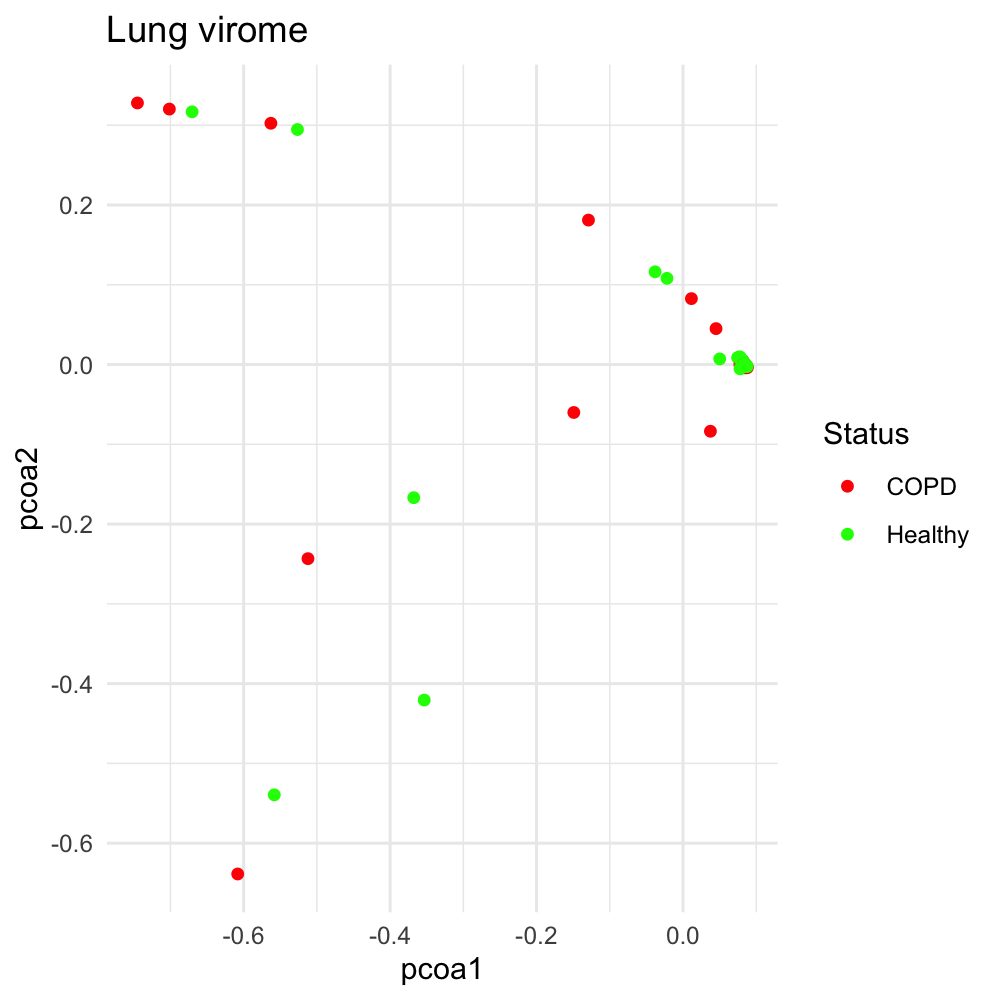

In [55]:
%%R -i t_lung_norm -w 5 -h 5 --units in -r 200
# import df from global environment
# make default figure size 5 by 5 inches with 200 dpi resolution

#install.packages(c("vegan", "tidyr", "ecodist", "ape","ggplot2"),repos='http://cran.us.r-project.org', quiet=TRUE) # rest omitted

library("vegan")
library("tidyr")
library("ecodist")
library(ape)
library(ggplot2)

lung <- t_lung_norm[1:(length(t_lung_norm)-5)]

dist <- vegan::vegdist(lung, method = "bray")
pcoa <- ecodist::pco(dist)

pcoa_df <- data.frame(pcoa1 = pcoa$vectors[,1], 
                                  pcoa2 = pcoa$vectors[,2])

# Add the status column from your original data frame
pcoa_df$Status <- t_lung_norm$Status

# Create a PCoA plot with ggplot2
pcoa_plot <- ggplot(pcoa_df, aes(x = pcoa1, y = pcoa2, color = Status)) +
  geom_point() +
  scale_color_manual(values = c("COPD" = "red", "Healthy" = "green")) +  # Customize colors
  labs(color = "Status") +  # Label for the legend
  ggtitle("Lung virome") +  # Title of the plot
  theme_minimal()  # Optional: Adjust plot theme

# Show the plot
print(pcoa_plot)

In [56]:
merged_counts_norm = merged_counts.apply(lambda x: x/x.sum(), axis=0)
t_merged_counts_norm = merged_counts_norm.transpose()
t_merged_counts_norm["Niche"] = "Gut"
t_merged_counts_norm.loc[lung, "Niche"] = "Lung Healthy"
t_merged_counts_norm.loc[copd, "Niche"] = "Lung COPD"
t_merged_counts_norm.to_csv(directory + "/transposed_norm_counts.txt", sep='\t', index=False) 


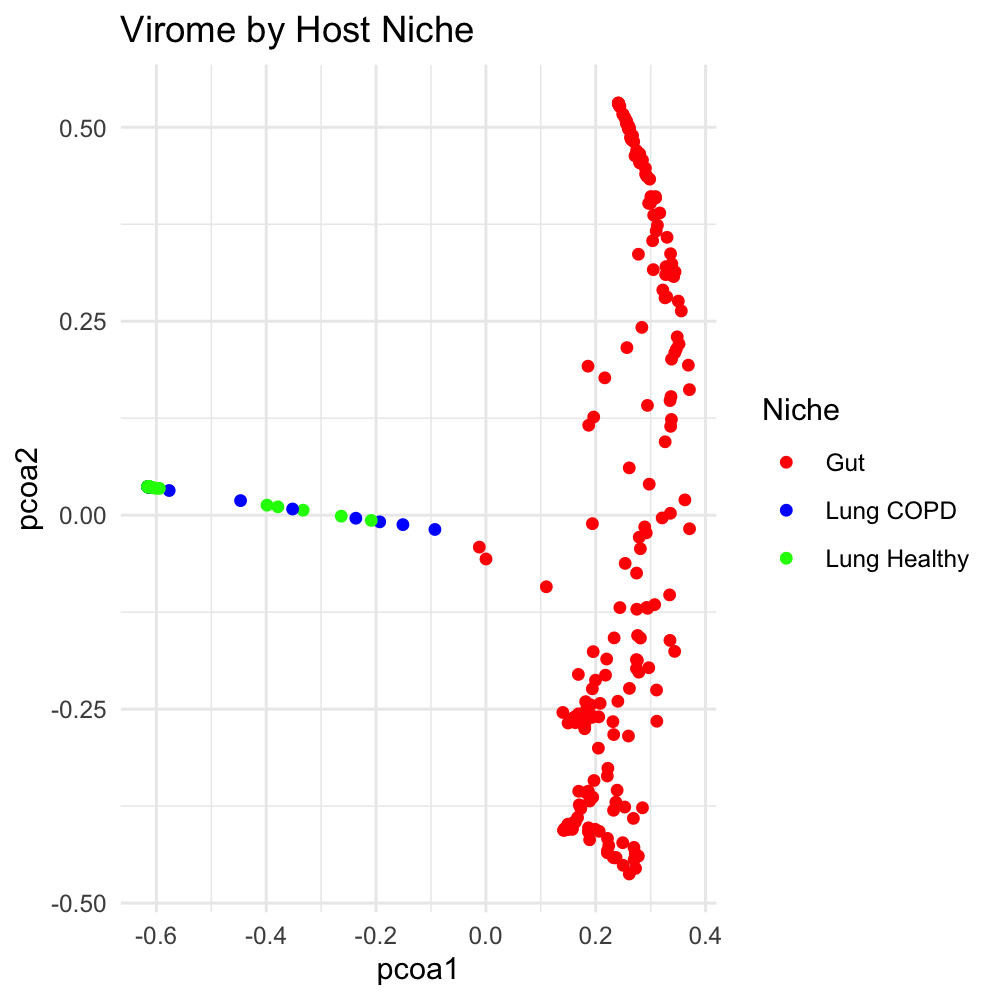

In [57]:
%%R -i t_merged_counts_norm -w 5 -h 5 --units in -r 200

df <- t_merged_counts_norm[1:(length(t_merged_counts_norm)-5)]

dist <- vegan::vegdist(df, method = "bray")
pcoa <- ecodist::pco(dist)

pcoa_df <- data.frame(pcoa1 = pcoa$vectors[,1], 
                                  pcoa2 = pcoa$vectors[,2])

# Add the status column from your original data frame
pcoa_df$Niche <- t_merged_counts_norm$Niche

# Create a PCoA plot with ggplot2
pcoa_plot <- ggplot(pcoa_df, aes(x = pcoa1, y = pcoa2, color = Niche)) +
  geom_point() +
  scale_color_manual(values = c("Gut" = "red", "Lung Healthy" = "green", "Lung COPD" = "blue")) +  # Customize colors
  labs(color = "Niche") +  # Label for the legend
  ggtitle("Virome by Host Niche") +  # Title of the plot
  theme_minimal()  # Optional: Adjust plot theme

# Show the plot
print(pcoa_plot)